In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
from Test import *

In [2]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [ ]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph( 100,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

# Hyperparameters
input_size = 28 * 28        # MNIST images are 28x28 pixels
hidden_size = 128           # Number of neurons in the hidden layer
num_classes = 10            # Number of output classes (digits 0-9)
num_epochs = 3              # Number of local training epochs per aggregation 
batch_size = 64             # Batch size for training
learning_rate = 0.01        # Learning rate for the optimizer
num_clients = num_nodes     # Number of clients 
num_rounds = 5              # Number of aggregation rounds
threshold = 0.02            # Loss threshold for stopping criteria

percentageCorrupt = 1/12    #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_clients) #Selection of Corrupt Clients

tolerance=-1                #PDMM tolerance
c=0.5                       #PDMM c
max_iters=5000             #PDMM max iterations (not transmissions)

var = 30000                  # Standard deviation for Gaussian noise
mean = 200                    # Mean for Gaussian noise
Target = np.random.randint(1, num_clients) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack



num_nodes: 100
IteNumber of Corrupt nodesration 8, Corrupt nodes: [67 42 21 79 88 95  6 47]


In [4]:
# Device configuration (use GPU if available)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
# Define the 1-layer MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                          # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Second fully connected layer

    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the input tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [5]:
def split_dataset(dataset, num_clients):
    dataset_size = len(dataset)
    data_per_client = dataset_size // num_clients
    split_sizes = [data_per_client] * num_clients

    # Distribute any remaining data equally among the first few clients
    for i in range(dataset_size % num_clients):
        split_sizes[i] += 1

    datasets = []
    for size in split_sizes:
        # Randomly select indices for each client
        indices = np.random.choice(range(dataset_size), size=size, replace=False)
        datasets.append(Subset(dataset, indices))
    return datasets

In [ ]:
def main():
    # MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),                      
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the pixel values 
    ])

    # Download the MNIST dataset
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True
    )

    # Split the training dataset into subsets for each client
    client_datasets = split_dataset(train_dataset, num_clients)

    # Initialize the global model
    global_model = MLP(input_size, hidden_size, num_classes).to(device)
    global_model2 = MLP(input_size, hidden_size, num_classes).to(device)
    global_model.train()

    # Loss and optimizer (used for evaluation on the test set)
    criterion = nn.CrossEntropyLoss()

    # Lists to keep track of metrics
    global_train_losses = []
    test_losses = []
    test_accuracies = []
    PDMM_error = []
  

    test_losses2 = []
    test_accuracies2 = []

    for round in range(num_rounds):
        print(f'\n--- Round {round+1} of {num_rounds} ---')
        
        # Each client trains on its local data
        local_models = []
        local_models2 = []
        for client_idx in range(num_clients):
            print(f'\nClient {client_idx+1}/{num_clients} training on local data...')
            local_model = train_local_model(client_datasets[client_idx], global_model, num_epochs)
            local_models.append(local_model)
            
        TrueAvg = aggregate_models2(global_model, local_models)
        # Aggregate the local models to update the global model

        local_models = CorruptData(CorruptClients, local_models, typeAttack, var, mean, Target,num_clients,scale)

        global_model, PDMM_error = aggregate_models(global_model, local_models, G, tolerance, c, max_iters, TrueAvg)
        global_model2= aggregate_models2(global_model2, local_models)
        
        # Evaluate the global model on the test dataset
        test_loss, test_accuracy = evaluate(global_model, test_dataset, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Evaluate the global model on the test dataset
        test_loss2, test_accuracy2 = evaluate(global_model2, test_dataset, criterion)
        test_losses2.append(test_loss2)
        test_accuracies2.append(test_accuracy2)

        print(f'\nAfter Round {round+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
            # Plot test accuracy and loss over rounds

        plt.figure(figsize=(10, 4))
        # Plot accuracy
        plt.plot(range(len(PDMM_error)), PDMM_error, label='PDMM convergenc')
        plt.yscale('log')
        plt.title('PDMM erorr over tranmission rounds')
        plt.xlabel('Transmission Round')
        plt.ylabel('Error (%)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        print(f'\nAfter Round {round+1}: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%')

        # Check stopping criteria
        if test_loss <= threshold:
            print(f'\nLoss threshold reached. Stopping training.')
            break

    # Plot test accuracy and loss over rounds
    rounds = range(1, len(test_accuracies) + 1)
    plt.figure(figsize=(10, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(rounds, test_accuracies, 'ro-', label='Test Accuracy')
    plt.title('Test Accuracy over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(rounds, test_losses, 'bo-', label='Test Loss')
    plt.title('Test Loss over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot test accuracy and loss over rounds
    rounds = range(1, len(test_accuracies2) + 1)
    plt.figure(figsize=(10, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(rounds, test_accuracies2, 'ro-', label='Test Accuracy')
    plt.title('Test Accuracy over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(rounds, test_losses2, 'bo-', label='Test Loss')
    plt.title('Test Loss over Rounds')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# def CorruptData(Corrupt, local_models, typeAttack, std, mean, Target, num_clients):
#     if typeAttack == 0:
#         return local_models
    
#     #CopiedModel = copy.deepcopy(local_models[np.random.randint(1, num_clients)])
#     CopiedModel = copy.deepcopy(local_models[Target])

#     for i in range(num_clients):
#         if Corrupt[i] == 1:
#             if typeAttack == 1:
#                 for param in local_models[i].parameters():
#                     param.data = torch.rand_like(param.data) * std + mean
#                 #local_models[i] = torch.rand_like(local_models[i]) * std + mean
#             elif typeAttack == 2:
#                 #local_models[i] = CopiedModel
#                 local_models[i].load_state_dict(copy.deepcopy(CopiedModel.state_dict()))
                
#     return local_models

In [8]:
def trimmed(y_values):
    """
    Adjusts y_values by setting the maximum and minimum values at each tensor position across neighbors to zero.

    Parameters:
    y_values (dict): A dictionary mapping neighbor indices to tensors.

    Returns:
    dict: Adjusted y_values with max and min values set to zero at each tensor position.
    """
    import torch

    # Get the list of neighbors and their corresponding tensors
    neighbors = list(y_values.keys())
    tensors = [y_values[j] for j in neighbors]  # List of tensors

    # Stack tensors to create a tensor of shape (num_neighbors, ...)
    tensor_stack = torch.stack(tensors, dim=0)  # Shape: (num_neighbors, ...)

    # Compute the maximum and minimum values across neighbors at each tensor position
    max_tensor, _ = torch.max(tensor_stack, dim=0, keepdim=True)  # Shape: (1, ...)
    min_tensor, _ = torch.min(tensor_stack, dim=0, keepdim=True)  # Shape: (1, ...)

    # Create masks for positions where tensors have max or min values
    max_mask = (tensor_stack == max_tensor)
    min_mask = (tensor_stack == min_tensor)

    # Combine masks to identify positions to zero out
    mask = max_mask | min_mask  # Shape: (num_neighbors, ...)

    # Create a copy of the tensor stack to adjust
    adjusted_tensor_stack = tensor_stack.clone()

    # Set max and min values to zero at the corresponding positions
    adjusted_tensor_stack[mask] = 0

    # Convert the adjusted tensor stack back to a list of tensors for each neighbor
    adjusted_tensors = [adjusted_tensor_stack[k] for k in range(adjusted_tensor_stack.shape[0])]

    # Map the adjusted tensors back to their respective neighbors
    adjusted_y_values = {j: adjusted_tensors[k] for k, j in enumerate(neighbors)}

    return adjusted_y_values


In [9]:

def train_local_model(dataset, global_model, num_epochs):
    """Train a local model on a client's data."""
    model = MLP(input_size, hidden_size, num_classes).to(device)
    model.load_state_dict(global_model.state_dict())  # Initialize with global model weights
    model.train()

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        #params = list(model.parameters())

    return model

In [10]:
def aggregate_models2(avg_model, local_models):
   """Aggregate local models to update the global model."""
   global_dict = avg_model.state_dict()
   # Initialize the global weights as zeros
   for key in global_dict.keys():
       global_dict[key] = torch.zeros_like(global_dict[key])
       #print(f"Parameter Key: {key}")
       #print(f"Parameter Shape: {global_dict[key].shape}")
       #print(f"Parameter Values:\n{global_dict[key]}\n")    
       
   # Sum the weights from all local models
   for local_model in local_models:
       local_dict = local_model.state_dict()
       for key in global_dict.keys():
           global_dict[key] += local_dict[key]

   # Average the weights
   for key in global_dict.keys():
       global_dict[key] = global_dict[key] / len(local_models)

   # Load the averaged weights into the global model
   avg_model.load_state_dict(global_dict)
   return avg_model

In [11]:
#Working PDMM CODE

def aggregate_models(pdmm_model, local_models, G, tolerance, c, max_iters, TrueAvg):

    # Initialize variables
    num_nodes = G.number_of_nodes()
    converged = False
    count = 0
    Error =[]

    # Extract state_dicts from local models
    local_dicts = [model.state_dict() for model in local_models]
    global_dict = pdmm_model.state_dict()

    # Initialize variables for PDMM
    x = [{} for _ in range(num_nodes)]  # Primal variables for each node
    z = [{} for _ in range(num_nodes)]  # Dual variables between nodes
    y = [{} for _ in range(num_nodes)]  # Auxiliary variables
    A_ij = calc_incidence_nested(G)     # Incidence matrix

    # Initialize x with local models and move to device
    for i in range(num_nodes):
        for key in global_dict.keys():
            x[i][key] = local_dicts[i][key].clone()

    # Initialize z and y
    for i in range(num_nodes):
        z[i] = {}
        y[i] = {}
        for j in G.neighbors(i):
            z[i][j] = {}
            y[i][j] = {}
            for key in global_dict.keys():
                z[i][j][key] = torch.zeros_like(global_dict[key])
                y[i][j][key] = torch.zeros_like(global_dict[key])
         
    # PDMM Iteration
    while not converged and count < max_iters:
        # Select random node
        i = np.random.randint(0, num_nodes)

        # Update x_i
        x_i = {}
        for key in global_dict.keys():
            # Start with local model parameter (t_i)
            x_i[key] = local_dicts[i][key].clone()
            # Subtract the influence of dual variables
            for j in G.neighbors(i):
                # Ensure z[i][j][key] exists
                if key not in z[i][j]:
                    z[i][j][key] = torch.zeros_like(global_dict[key])
                x_i[key] -= A_ij[i][j] * z[i][j][key]
            # Normalize
            x_i[key] = x_i[key] / (1 + c * G.degree[i])

        # Update y_ij
        for j in G.neighbors(i):
            for key in global_dict.keys():
                y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x_i[key]

        # Check convergence
        norm_diff = 0
        total_elements = 0  
        for key in global_dict.keys():
            diff = x_i[key] - global_dict[key]
            norm_diff += torch.norm(diff).item()
            total_elements += diff.numel()
            #print(total_elements)

        norm_diff = norm_diff / total_elements
        Error.append(norm_diff)
        
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            converged = True

        # Update z_ij
        for j in G.neighbors(i):
            for key in global_dict.keys():
                # plot_distribution(y[j][i][key])
                #stats = get_distribution_summary(y[j][i][key])
                # for key, value in stats.items():
                #     print(f"{key}: {value:.4f}")
                # print(y[j][i][key].size())
                z[i][j][key] = y[j][i][key]

        # Update global model parameters
        for key in global_dict.keys():
            global_dict[key] = x_i[key].clone()

        if count % 2000 == 0:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.4f}')
            # Compare PDMM model with averaging model here
            # This requires having a separate avg_model outside this function
            # So, this print statement should be handled externally
        count += 1

    # Load the updated state_dict into the PDMM global model
    pdmm_model.load_state_dict(global_dict)
    return pdmm_model, Error


In [12]:
# #Working PDMM CODE

# def aggregate_models(pdmm_model, local_models, G, tolerance, c, max_iters, TrueAvg):

#     # Initialize variables
#     num_nodes = G.number_of_nodes()
#     converged = False
#     count = 0
#     Error =[]

#     # Extract state_dicts from local models
#     local_dicts = [model.state_dict() for model in local_models]
#     global_dict = pdmm_model.state_dict()

#     # Initialize variables for PDMM
#     x = [{} for _ in range(num_nodes)]  # Primal variables for each node
#     z = [{} for _ in range(num_nodes)]  # Dual variables between nodes
#     y = [{} for _ in range(num_nodes)]  # Auxiliary variables
#     A_ij = calc_incidence_nested(G)     # Incidence matrix

#     # Initialize x with local models and move to device
#     for i in range(num_nodes):
#         for key in global_dict.keys():
#             x[i][key] = local_dicts[i][key].clone()

#     # Initialize z and y
#     for i in range(num_nodes):
#         z[i] = {}
#         y[i] = {}
#         for j in G.neighbors(i):
#             z[i][j] = {}
#             y[i][j] = {}
#             for key in global_dict.keys():
#                 z[i][j][key] = torch.zeros_like(global_dict[key])
#                 y[i][j][key] = torch.zeros_like(global_dict[key])
         
#     # PDMM Iteration
#     while not converged and count < max_iters:
#         # Select random node
#         i = np.random.randint(0, num_nodes)

#         # Update x_i
#         x_i = {}
#         for key in global_dict.keys():
#             # Start with local model parameter (t_i)
#             x_i[key] = local_dicts[i][key].clone()
#             # Subtract the influence of dual variables
#             for j in G.neighbors(i):
#                 # Ensure z[i][j][key] exists
#                 if key not in z[i][j]:
#                     z[i][j][key] = torch.zeros_like(global_dict[key])
#                 x_i[key] -= A_ij[i][j] * z[i][j][key]
#             # Normalize
#             x_i[key] = x_i[key] / (1 + c * G.degree[i])

#         # Update y_ij
#         for j in G.neighbors(i):
#             for key in global_dict.keys():
#                 y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x_i[key]

#         # Check convergence
#         norm_diff = 0
#         total_elements = 0  
#         for key in global_dict.keys():
#             diff = x_i[key] - global_dict[key]
#             norm_diff += torch.norm(diff).item()
#             total_elements += diff.numel()
#             #print(total_elements)

#         norm_diff = norm_diff / total_elements
#         Error.append(norm_diff)
        
#         if norm_diff < tolerance:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
#             converged = True

#         # Update z_ij
#         for j in G.neighbors(i):
#             for key in global_dict.keys():
#                 z[i][j][key] = y[j][i][key]

#         # Update global model parameters
#         for key in global_dict.keys():
#             global_dict[key] = x_i[key].clone()

#         if count % 2000 == 0:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.4f}')
#             # Compare PDMM model with averaging model here
#             # This requires having a separate avg_model outside this function
#             # So, this print statement should be handled externally
#         count += 1

#     # Load the updated state_dict into the PDMM global model
#     pdmm_model.load_state_dict(global_dict)
#     return pdmm_model, Error


In [13]:
def evaluate(model, test_dataset, criterion):
    """Evaluate the model on the test dataset."""
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Predicted class is the one with the highest score
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(test_loader)
        accuracy = 100 * correct / total

    return avg_loss, accuracy


--- Round 1 of 5 ---

Client 1/100 training on local data...
Epoch [1/3], Loss: 2.2401
Epoch [2/3], Loss: 2.0809
Epoch [3/3], Loss: 1.9297

Client 2/100 training on local data...
Epoch [1/3], Loss: 2.2349
Epoch [2/3], Loss: 2.0898
Epoch [3/3], Loss: 1.9416

Client 3/100 training on local data...
Epoch [1/3], Loss: 2.2151
Epoch [2/3], Loss: 2.0586
Epoch [3/3], Loss: 1.8808

Client 4/100 training on local data...
Epoch [1/3], Loss: 2.2234
Epoch [2/3], Loss: 2.0692
Epoch [3/3], Loss: 1.9158

Client 5/100 training on local data...
Epoch [1/3], Loss: 2.2137
Epoch [2/3], Loss: 2.0380
Epoch [3/3], Loss: 1.8560

Client 6/100 training on local data...
Epoch [1/3], Loss: 2.2197
Epoch [2/3], Loss: 2.0579
Epoch [3/3], Loss: 1.8912

Client 7/100 training on local data...
Epoch [1/3], Loss: 2.2085
Epoch [2/3], Loss: 2.0449
Epoch [3/3], Loss: 1.8852

Client 8/100 training on local data...
Epoch [1/3], Loss: 2.2375
Epoch [2/3], Loss: 2.0645
Epoch [3/3], Loss: 1.8860

Client 9/100 training on local da

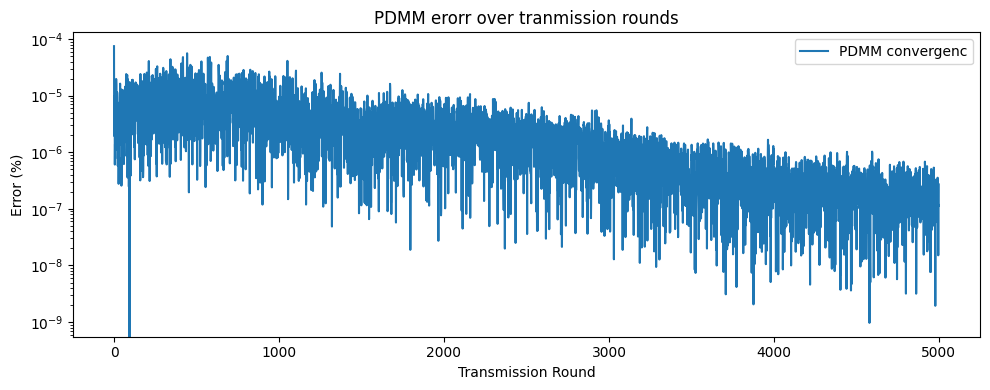


After Round 1: Test Loss: 1.8407, Test Accuracy: 60.99%

--- Round 2 of 5 ---

Client 1/100 training on local data...
Epoch [1/3], Loss: 1.8036
Epoch [2/3], Loss: 1.6328
Epoch [3/3], Loss: 1.5002

Client 2/100 training on local data...
Epoch [1/3], Loss: 1.8056
Epoch [2/3], Loss: 1.6457
Epoch [3/3], Loss: 1.5034

Client 3/100 training on local data...
Epoch [1/3], Loss: 1.7753
Epoch [2/3], Loss: 1.6070
Epoch [3/3], Loss: 1.4571

Client 4/100 training on local data...
Epoch [1/3], Loss: 1.7930
Epoch [2/3], Loss: 1.6377
Epoch [3/3], Loss: 1.4810

Client 5/100 training on local data...
Epoch [1/3], Loss: 1.7601
Epoch [2/3], Loss: 1.5801
Epoch [3/3], Loss: 1.4267

Client 6/100 training on local data...
Epoch [1/3], Loss: 1.7816
Epoch [2/3], Loss: 1.6127
Epoch [3/3], Loss: 1.4497

Client 7/100 training on local data...
Epoch [1/3], Loss: 1.7621
Epoch [2/3], Loss: 1.5975
Epoch [3/3], Loss: 1.4446

Client 8/100 training on local data...
Epoch [1/3], Loss: 1.7688
Epoch [2/3], Loss: 1.5765
Epo

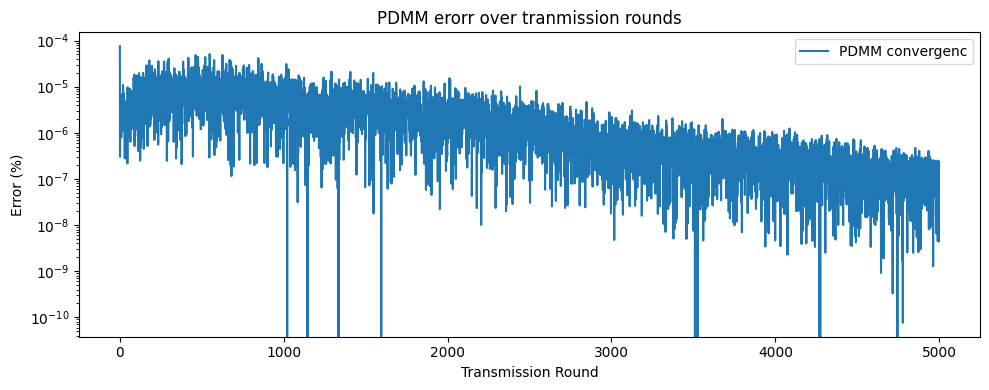


After Round 2: Test Loss: 1.3968, Test Accuracy: 74.36%

--- Round 3 of 5 ---

Client 1/100 training on local data...
Epoch [1/3], Loss: 1.3817
Epoch [2/3], Loss: 1.2567
Epoch [3/3], Loss: 1.1375

Client 2/100 training on local data...
Epoch [1/3], Loss: 1.3934
Epoch [2/3], Loss: 1.2741
Epoch [3/3], Loss: 1.1566

Client 3/100 training on local data...
Epoch [1/3], Loss: 1.3517
Epoch [2/3], Loss: 1.2226
Epoch [3/3], Loss: 1.1167

Client 4/100 training on local data...
Epoch [1/3], Loss: 1.3701
Epoch [2/3], Loss: 1.2388
Epoch [3/3], Loss: 1.1446

Client 5/100 training on local data...
Epoch [1/3], Loss: 1.3274
Epoch [2/3], Loss: 1.1756
Epoch [3/3], Loss: 1.0615

Client 6/100 training on local data...
Epoch [1/3], Loss: 1.3468
Epoch [2/3], Loss: 1.2085
Epoch [3/3], Loss: 1.0866

Client 7/100 training on local data...
Epoch [1/3], Loss: 1.3361
Epoch [2/3], Loss: 1.2152
Epoch [3/3], Loss: 1.0957

Client 8/100 training on local data...
Epoch [1/3], Loss: 1.3276
Epoch [2/3], Loss: 1.1955
Epo

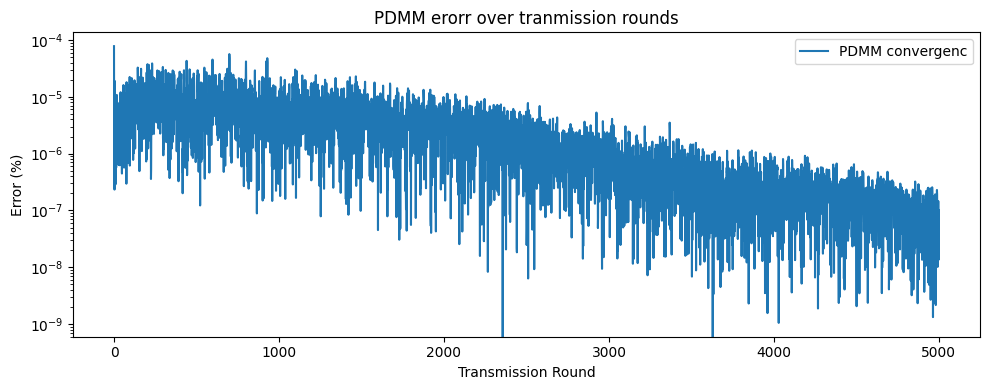


After Round 3: Test Loss: 1.0690, Test Accuracy: 80.30%

--- Round 4 of 5 ---

Client 1/100 training on local data...
Epoch [1/3], Loss: 1.0740
Epoch [2/3], Loss: 1.0055
Epoch [3/3], Loss: 0.9157

Client 2/100 training on local data...
Epoch [1/3], Loss: 1.1024
Epoch [2/3], Loss: 1.0215
Epoch [3/3], Loss: 0.9397

Client 3/100 training on local data...
Epoch [1/3], Loss: 1.0692
Epoch [2/3], Loss: 0.9781
Epoch [3/3], Loss: 0.9048

Client 4/100 training on local data...
Epoch [1/3], Loss: 1.0914
Epoch [2/3], Loss: 0.9858
Epoch [3/3], Loss: 0.9130

Client 5/100 training on local data...
Epoch [1/3], Loss: 1.0092
Epoch [2/3], Loss: 0.9169
Epoch [3/3], Loss: 0.8629

Client 6/100 training on local data...
Epoch [1/3], Loss: 1.0403
Epoch [2/3], Loss: 0.9576
Epoch [3/3], Loss: 0.8782

Client 7/100 training on local data...
Epoch [1/3], Loss: 1.0387
Epoch [2/3], Loss: 0.9653
Epoch [3/3], Loss: 0.8893

Client 8/100 training on local data...
Epoch [1/3], Loss: 1.0248
Epoch [2/3], Loss: 0.9311
Epo

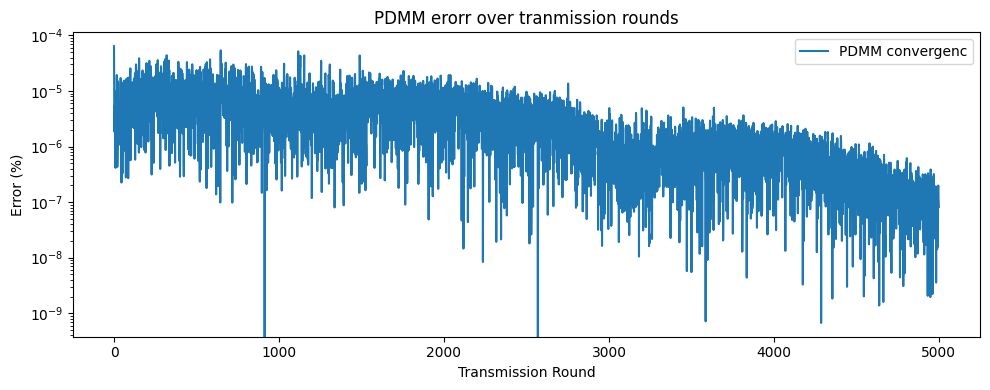


After Round 4: Test Loss: 0.8672, Test Accuracy: 82.77%

--- Round 5 of 5 ---

Client 1/100 training on local data...
Epoch [1/3], Loss: 0.8998
Epoch [2/3], Loss: 0.8356
Epoch [3/3], Loss: 0.7771

Client 2/100 training on local data...
Epoch [1/3], Loss: 0.9198
Epoch [2/3], Loss: 0.8655
Epoch [3/3], Loss: 0.8024

Client 3/100 training on local data...
Epoch [1/3], Loss: 0.8790
Epoch [2/3], Loss: 0.8015
Epoch [3/3], Loss: 0.7664

Client 4/100 training on local data...
Epoch [1/3], Loss: 0.8892
Epoch [2/3], Loss: 0.8151
Epoch [3/3], Loss: 0.7718

Client 5/100 training on local data...
Epoch [1/3], Loss: 0.8298
Epoch [2/3], Loss: 0.7577
Epoch [3/3], Loss: 0.7156

Client 6/100 training on local data...
Epoch [1/3], Loss: 0.8486
Epoch [2/3], Loss: 0.8151
Epoch [3/3], Loss: 0.7473

Client 7/100 training on local data...
Epoch [1/3], Loss: 0.8481
Epoch [2/3], Loss: 0.7858
Epoch [3/3], Loss: 0.7514

Client 8/100 training on local data...
Epoch [1/3], Loss: 0.8405
Epoch [2/3], Loss: 0.7838
Epo

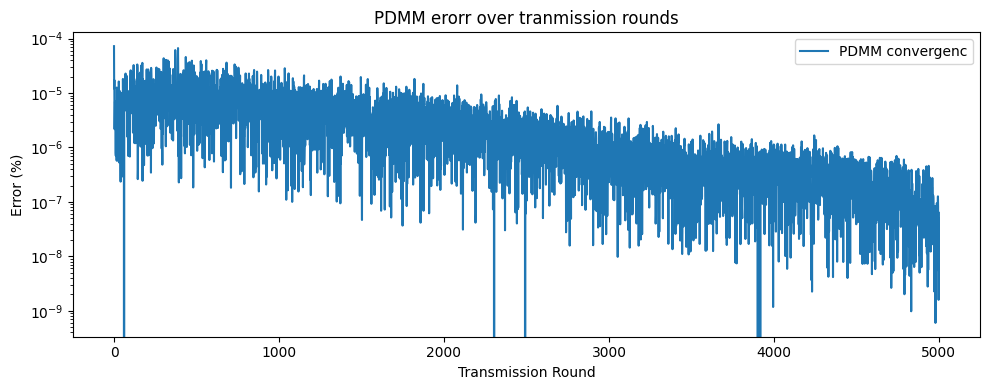


After Round 5: Test Loss: 0.7396, Test Accuracy: 84.40%


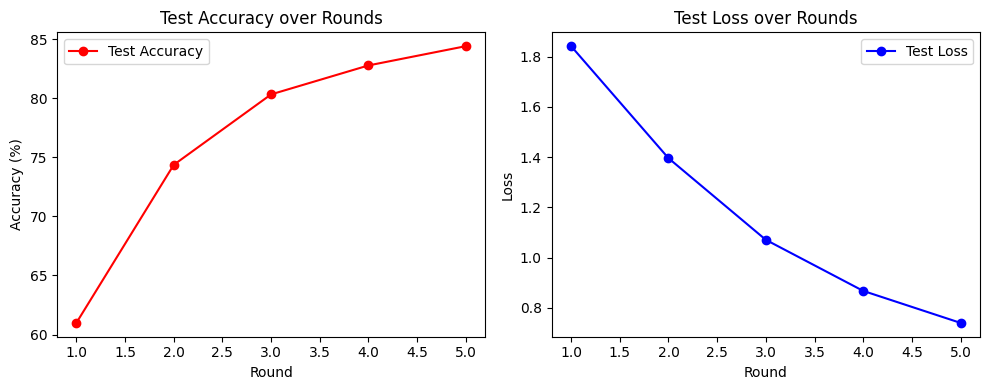

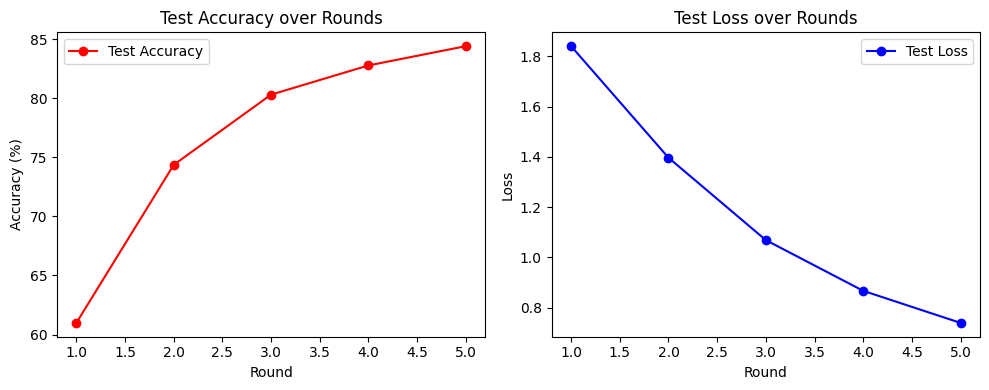

In [14]:
if __name__ == '__main__':
    main()

In [15]:
##Working PDMM CODE

# def aggregate_models(pdmm_model, local_models, G, tolerance, c, max_iters, TrueAvg):
#     """Aggregate local models to update the global model using PDMM_async."""

#     # Initialize variables
#     num_nodes = G.number_of_nodes()
#     converged = False
#     count = 0
#     Error =[]

#     # Extract state_dicts from local models
#     local_dicts = [model.state_dict() for model in local_models]
#     global_dict = pdmm_model.state_dict()

#     # Initialize variables for PDMM
#     x = [{} for _ in range(num_nodes)]  # Primal variables for each node
#     z = [{} for _ in range(num_nodes)]  # Dual variables between nodes
#     y = [{} for _ in range(num_nodes)]  # Auxiliary variables
#     A_ij = calc_incidence_nested(G)     # Incidence matrix

#     # Initialize x with local models and move to device
#     for i in range(num_nodes):
#         for key in global_dict.keys():
#             x[i][key] = local_dicts[i][key].clone()

#     # Initialize z and y
#     for i in range(num_nodes):
#         z[i] = {}
#         y[i] = {}
#         for j in G.neighbors(i):
#             z[i][j] = {}
#             y[i][j] = {}
#             for key in global_dict.keys():
#                 z[i][j][key] = torch.zeros_like(global_dict[key])
#                 y[i][j][key] = torch.zeros_like(global_dict[key])
         
#     # PDMM Iteration
#     while not converged and count < max_iters:
#         # Select random node
#         i = np.random.randint(0, num_nodes)

#         # Update x_i
#         x_i = {}
#         for key in global_dict.keys():
#             # Start with local model parameter (t_i)
#             x_i[key] = local_dicts[i][key].clone()
#             # Subtract the influence of dual variables
#             for j in G.neighbors(i):
#                 # Ensure z[i][j][key] exists
#                 if key not in z[i][j]:
#                     z[i][j][key] = torch.zeros_like(global_dict[key])
#                 x_i[key] -= A_ij[i][j] * z[i][j][key]
#             # Normalize
#             x_i[key] = x_i[key] / (1 + c * G.degree[i])

#         # Update y_ij
#         for j in G.neighbors(i):
#             for key in global_dict.keys():
#                 y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x_i[key]

#         # Check convergence
#         norm_diff = 0
#         for key in global_dict.keys():
#             norm_diff += torch.norm(x_i[key] - TrueAvg.state_dict()[key]).item()

#         norm_diff = norm_diff / len(global_dict.keys())
#         Error.append(norm_diff)
        
#         if norm_diff < tolerance:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
#             converged = True

#         # Update z_ij
#         for j in G.neighbors(i):
#             for key in global_dict.keys():
#                 z[i][j][key] = y[j][i][key]

#         # Update global model parameters
#         for key in global_dict.keys():
#             global_dict[key] = x_i[key].clone()

#         if count % 2000 == 0:
#             print(f'Iteration {count}, Norm of difference: {norm_diff:.4f}')
#             # Compare PDMM model with averaging model here
#             # This requires having a separate avg_model outside this function
#             # So, this print statement should be handled externally
#         count += 1

#     # Load the updated state_dict into the PDMM global model
#     pdmm_model.load_state_dict(global_dict)
#     return pdmm_model, Error
